<a href="https://colab.research.google.com/github/nematatu/Colab-Python/blob/master/kasoon_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q bing_image_downloader
!pip install -q google-cloud-vision
!pip install -q tensorflow
!pip install -q Pillow
!pip -q install icrawler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.1/442.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
from bing_image_downloader import downloader
from google.cloud import vision
import google.cloud.vision_v1.types as types
from PIL import Image as PILImage
from PIL import ImageOps
import os
import random
import shutil
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import glob
from scipy import ndimage
from icrawler.builtin import GoogleImageCrawler

from google.colab import drive
from IPython.display import Image,display_jpeg

In [ ]:
!rm -rf ./ds ./img

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!readlink -f drive/MyDrive/Colab\ Notebooks/kasoon_colab/fluted-oath-407809-b8c332499f57.json

/content/drive/MyDrive/Colab Notebooks/kasoon_colab/fluted-oath-407809-b8c332499f57.json


In [ ]:
google_auth_path='/content/drive/MyDrive/Colab\ Notebooks/kasoon_colab/fluted-oath-407809-b8c332499f57.json'

In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] ='/content/drive/MyDrive/開発/kasoon/fluted-oath-407809-b8c332499f57.json'


In [ ]:
from bing_image_downloader import downloader
query_string = '伊織もえ'

downloader.download(query_string,limit=200,output_dir=r'./img',adult_filter_off=False,timeout=500,verbose= True)

In [ ]:
query_string="伊織もえ"


if not os.path.exists('./img'):
  os.mkdir('./img')
save_directory = os.path.join("./img",query_string) # 保存先ディレクトリ
if not os.path.exists(save_directory):
  os.mkdir(save_directory)
google_crawler = GoogleImageCrawler(storage={"root_dir": save_directory})
num_images = 100 # 取得する画像の数
google_crawler.crawl(keyword=query_string, max_num=num_images)

ERROR:downloader:Response status code 404, file https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Comic_Market_99_Day_1_Iori_Moe_%2851823744431%29.jpg
ERROR:downloader:Response status code 400, file https://thumbor.4gamers.com.tw/LFSLjZq45SX9SdPRmwI6JhY_Spg\u003d/adaptive-fit-in/1200x1200/filters:no_upscale():extract_cover():format(jpeg):quality(85)/https%3A%2F%2Fugc-media.4gamers.com.tw%2Fpuku-prod-zh%2Fanonymous-story%2F4a0053f5-8994-4ea9-bc50-624b2bd682cc.jpg
ERROR:downloader:Response status code 403, file https://bunshun.ismcdn.jp/mwimgs/7/4/750wm/img_749756074560f6443a85110b7e1d594c569631.jpg


In [ ]:
!ls -l img/伊織もえ|wc -l

66


In [ ]:
display_jpeg(Image(f'img/{query_string}/000010.jpg'))

FileNotFoundError: ignored

In [ ]:
#def: 顔の検知
def detect_face(image_path):
    client=vision.ImageAnnotatorClient()
    #コードブロックが終わったら自動でfileが閉じる
    #メモリの効率化
    #引数で取ったiamge_pathを'rb'バイナリファイルを読み込む
    with open(image_path, 'rb') as file:
        #読み込んだバイナリファイルを画像形式に変換している
        image=types.Image(content=file.read())
        #GCV APIのface_detection()を使って画像内の顔を検出する
        #そのうち、顔の情報を含むface_annotationsオブジェクトを返す
        annotations=client.face_detection(image=image).face_annotations

    face_boxes=[]

    for annotation in annotations:
        #annotation(顔の情報)の境界ボックス(bounding_poly)の座標情報(vertices)を取得
        #リスト内包表記で、うちx座標のみをリストに格納
        x_s=[vertex.x for vertex in annotation.bounding_poly.vertices]
        y_s=[vertex.y for vertex in annotation.bounding_poly.vertices]
        face_boxes.append((min(x_s),min(y_s),max(x_s),max(y_s)))
    return face_boxes

In [ ]:
#def: データセットの分割
train_dir_path='./ds/train'
test_dir_path='./ds/test'

def split_dataset(image_dir_path):
  print("データセットの分割を開始します")
  file_list=os.listdir(image_dir_path)
  random.shuffle(file_list)

  dir_name=image_dir_path.split('/')[-1]
  train_size=int(len(file_list)*0.8)
  print(f"images:{int(len(file_list))}")
  print(f"train:{train_size}")
  if not os.path.exists('./ds'):
    os.mkdir('./ds')
    os.mkdir(train_dir_path)
    os.mkdir(test_dir_path)
    os.mkdir(os.path.join(test_dir_path,dir_name))
    os.mkdir(os.path.join(train_dir_path,dir_name))
  for i, file in enumerate(file_list):
    if i < train_size:
      shutil.copy(os.path.join(image_dir_path, file), os.path.join(train_dir_path,dir_name, file))
    else:
      shutil.copy(os.path.join(image_dir_path, file), os.path.join(test_dir_path, dir_name,file))
  print("データセットの分割が終了しました！")

In [ ]:
!printenv GOOGLE_APPLICATION_CREDENTIALS
#/content/drive/MyDrive/開発/kasoon/fluted-oath-407809-b8c332499f57.json

/content/drive/MyDrive/開発/kasoon/fluted-oath-407809-b8c332499f57.json


In [ ]:
#def: 底上げ
def false_buttom(in_dir):
  print(f"{query_string}の写真を水増しします")
  out_dir = "./img/Edited/" + query_string
  if not os.path.exists(os.path.join("./img","Edited")):
    os.mkdir(os.path.join("./img","Edited"))
  if not os.path.exists(out_dir):
    os.mkdir(out_dir)
  in_jpg = glob.glob(os.path.join(in_dir,'*'))
  for i in range(len(in_jpg)):
      img = cv2.imread(str(in_jpg[i]))
      print(str(in_jpg[i]))
      for ang in [-10, 0, 10]:
          img_rot = ndimage.rotate(img, ang)
          fileName = os.path.join(out_dir, str(i) + "_" + str(ang) + ".jpg")
          cv2.imwrite(str(fileName), img_rot)
          retval, img_thr = cv2.threshold(img_rot, 100, 255, cv2.THRESH_TOZERO)
          fileName = os.path.join(out_dir, str(i) + "_" + str(ang) + "thr.jpg")
          cv2.imwrite(str(fileName), img_thr)
          img_filter = cv2.GaussianBlur(img_rot, (5, 5), 0)
          fileName = os.path.join(out_dir, str(i) + "_" + str(ang) + "filter.jpg")
          cv2.imwrite(str(fileName), img_filter)
  print("画像の水増しに大成功しました！")

In [ ]:
#body
max_margin=0.2
image_dir_path=os.path.join('./img',query_string)
file_list=os.listdir(image_dir_path)
image_size=(128,128)

for img in file_list:
    new_img=os.path.join(image_dir_path,img)
    target_name=image_dir_path.split('/')[-1]
    print(new_img)

    if img.endswith('.jpg') or img.endswith('.png') or img.endswith('.jpeg'):
        #faces=img+'_face'
        #GoogleDriveのパスを空白を含めないディレクトリに変更したら行けた
        faces=detect_face(new_img)

        if len(faces)>0:
            #PILライブラリのImage.open()で画像を開く
            #from PIL import Image as PILImageとしたらいけた
            #恐らく、GoogleColab内でImageという変数が重複してる
            image=PILImage.open(new_img).convert('RGB')

            x1,y1,x2,y2=faces[0]
            w=x2-x1
            h=y2-y1

            spaces_x = min(x1, image.width - x2, int(float(w) * max_margin))
            spaces_y = min(y1,image.height-y2,int(float(h)*max_margin))
            margin=min(spaces_x,spaces_y)

            cropped_img=image.crop((
                x1-margin,
                y1-margin,
                x2+margin,
                y2+margin
            ))
            #ImageOps:切り取り
            cropped_img=ImageOps.contain(cropped_img,image_size)

            directory='face_cropped'
            new_directory=os.path.join('./img',directory,target_name)

            if not os.path.exists(os.path.join('./img',directory)):
              os.mkdir(os.path.join('./img',directory))
            if not os.path.exists(new_directory):
                os.mkdir(new_directory)

            cropped_img.save(os.path.join(new_directory,f'cropped_{img}'))

false_buttom(os.path.join("./img","face_cropped",query_string))
split_dataset(os.path.join('./img','Edited',query_string))



./img/伊織もえ/000055.jpg
./img/伊織もえ/000053.jpg
./img/伊織もえ/000054.jpg
./img/伊織もえ/000026.png
./img/伊織もえ/000058.jpg
./img/伊織もえ/000029.jpg
./img/伊織もえ/000040.jpg
./img/伊織もえ/000047.jpg
./img/伊織もえ/000039.jpg
./img/伊織もえ/000009.jpg
./img/伊織もえ/000049.jpg
./img/伊織もえ/000027.jpg
./img/伊織もえ/000041.jpg
./img/伊織もえ/000035.jpg
./img/伊織もえ/000018.jpg
./img/伊織もえ/000022.jpg
./img/伊織もえ/000014.jpg
./img/伊織もえ/000006.jpg
./img/伊織もえ/000042.jpg
./img/伊織もえ/000008.jpg
./img/伊織もえ/000023.jpg
./img/伊織もえ/000059.jpg
./img/伊織もえ/000025.jpg
./img/伊織もえ/000038.jpg
./img/伊織もえ/000013.jpg
./img/伊織もえ/000001.jpg
./img/伊織もえ/000011.jpg
./img/伊織もえ/000046.jpg
./img/伊織もえ/000007.jpg
./img/伊織もえ/000033.jpg
./img/伊織もえ/000032.jpg
./img/伊織もえ/000063.jpg
./img/伊織もえ/000017.jpg
./img/伊織もえ/000061.jpg
./img/伊織もえ/000044.jpg
./img/伊織もえ/000057.jpg
./img/伊織もえ/000048.jpg
./img/伊織もえ/000045.jpg
./img/伊織もえ/000034.jpg
./img/伊織もえ/000060.jpg
./img/伊織もえ/000036.jpg
./img/伊織もえ/000064.jpg
./img/伊織もえ/000050.jpg
./img/伊織もえ/000021.jpg
./img/伊織もえ/000051.jpg
./img/伊織もえ

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


./img/伊織もえ/000065.jpg
./img/伊織もえ/000024.jpg
./img/伊織もえ/000015.jpg
./img/伊織もえ/000056.jpg
./img/伊織もえ/000028.jpg
./img/伊織もえ/000052.jpg
./img/伊織もえ/000019.jpg
./img/伊織もえ/000031.jpg
./img/伊織もえ/000043.jpg
./img/伊織もえ/000030.jpg
./img/伊織もえ/000062.jpg
./img/伊織もえ/000016.jpg
./img/伊織もえ/000003.jpg
./img/伊織もえ/000005.jpg
./img/伊織もえ/000002.jpg
./img/伊織もえ/000037.jpg
./img/伊織もえ/000020.jpg
./img/伊織もえ/000012.jpg
./img/伊織もえ/000004.jpg
伊織もえの写真を水増しします
./img/face_cropped/伊織もえ/cropped_000009.jpg
./img/face_cropped/伊織もえ/cropped_000011.jpg
./img/face_cropped/伊織もえ/cropped_000059.jpg
./img/face_cropped/伊織もえ/cropped_000026.png
./img/face_cropped/伊織もえ/cropped_000002.jpg
./img/face_cropped/伊織もえ/cropped_000040.jpg
./img/face_cropped/伊織もえ/cropped_000033.jpg
./img/face_cropped/伊織もえ/cropped_000005.jpg
./img/face_cropped/伊織もえ/cropped_000047.jpg
./img/face_cropped/伊織もえ/cropped_000046.jpg
./img/face_cropped/伊織もえ/cropped_000017.jpg
./img/face_cropped/伊織もえ/cropped_000029.jpg
./img/face_cropped/伊織もえ/cropped_000010.png
./img/fa

In [ ]:
# file_list=os.listdir(os.path.join('./img','face_cropped',image_dir_path.split('/')[-1]))
# print(os.path.join('./img','face_cropped',image_dir_path.split('/')[-1]))
# file_num=int(len(file_list)*0.8)
# print(f"file_num:",file_num)
# for i, file in enumerate(file_list):
#   print(file.split('_')[-1].split('.')[0])
#   if i<file_num:
#     print(f"train{i}:{file}")
#   if i>file_num:
#     print(f"test{i}:{file}")

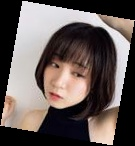

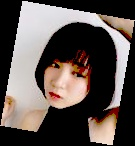

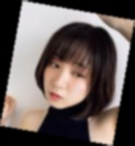

In [ ]:
display(Image("./img/Edited/伊織もえ/0_-10.jpg"))
display(Image("./img/Edited/伊織もえ/0_-10thr.jpg"))
display(Image("./img/Edited/伊織もえ/0_-10filter.jpg"))

In [ ]:
#画像ディレクトリの読み込み

#ここで伊織もえまで含めない
train_dir_path='./ds/train/'
test_dir_path='./ds/test/'
image_size=128
batch_size=3

train_datagen=ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=0.5
)

test_datagen=ImageDataGenerator(
    rescale=1./255
)

train_generator=train_datagen.flow_from_directory(
    train_dir_path,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator=test_datagen.flow_from_directory(
    test_dir_path,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 460 images belonging to 1 classes.
Found 116 images belonging to 1 classes.


In [ ]:
#!rm -rf ./ds

In [ ]:
#モデルの作成
num_categories=2
model = keras.Sequential()
#Conv2D:二次元の畳み込みレイヤを追加
#Conv(特徴を出力する数,(カーネルのサイズ),入力画像の大きさとチャンネル数。ここではRGBの3チャンネル)
model.add(keras.layers.Conv2D(32,(3,3),input_shape=(image_size,image_size,3)))
#活性化関数で非線形を導入することで複雑な学習ができるらしい
model.add(keras.layers.Activation('relu'))
#MaxPoolingで(2,2)で動きながらそこでの最大値のみを取る
#Convで特徴量を出力した後にやるのでデータサイズの効率化とか
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


#もう一回似たような処理をしてより精度を高める
model.add(keras.layers.Conv2D(32,(3,3)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

#もっかい
model.add(keras.layers.Conv2D(64,3,3))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

#Falttenで、出力された特徴量を一次元にする
model.add(keras.layers.Flatten())
#64個の結合層を追加
model.add(keras.layers.Dense(64))

model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=num_categories, activation="sigmoid"))

#オプティマイザ
adam=keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [ ]:
#学習
checkpoint_cb = keras.callbacks.ModelCheckpoint("snapshot/{epoch:03d}-.hdf5", save_best_only=True)
model.fit(
        train_generator,
        steps_per_epoch=batch_size,
        epochs=200,
        validation_data=test_generator,
        validation_steps=32,
        callbacks=[checkpoint_cb])

Epoch 1/200
3/3 [==============================] - 3s 558ms/step - loss: 1.4230 - accuracy: 0.8889 - val_loss: 1.4249 - val_accuracy: 1.0000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
3/3 [==============================] - 1s 408ms/step - loss: 1.4231 - accuracy: 1.0000 - val_loss: 1.4215 - val_accuracy: 1.0000
Epoch 3/200
3/3 [==============================] - 1s 461ms/step - loss: 1.4186 - accuracy: 0.8889 - val_loss: 1.4191 - val_accuracy: 1.0000
Epoch 4/200
3/3 [==============================] - 1s 578ms/step - loss: 1.4297 - accuracy: 1.0000 - val_loss: 1.4164 - val_accuracy: 1.0000
Epoch 5/200
3/3 [==============================] - 2s 808ms/step - loss: 1.4262 - accuracy: 0.8889 - val_loss: 1.4156 - val_accuracy: 1.0000
Epoch 6/200
3/3 [==============================] - 1s 457ms/step - loss: 1.4286 - accuracy: 0.7778 - val_loss: 1.4132 - val_accuracy: 1.0000
Epoch 7/200
3/3 [==============================] - 1s 344ms/step - loss: 1.4193 - accuracy: 1.0000 - val_loss: 1.4115 - val_accuracy: 1.0000
Epoch 8/200
3/3 [==============================] - 1s 405ms/step - loss: 1.4288 - accuracy: 1.0000 - val_loss: 1.4099 - val_accuracy: 1.0000
Epoch 9/200
3

In [ ]:
!ls ./ds/train/伊織もえ -l |grep -v '^d' |wc -l

461


In [ ]:
!ls ./img/face_cropped/伊織もえ -l |grep -v '^d' |wc -l

65


In [ ]:
#for i in range (len(os.listdir('img/face_cropped/伊織もえ'))):
#  display_jpeg(Image(f'img/face_cropped/{query_string}/cropped_Image_{i}.jpg'))

In [ ]:
print("test:{}".format(len(os.listdir("ds/test/伊織もえ"))))
print("train:{}".format(len(os.listdir("ds/train/伊織もえ"))))

test:116
train:460
